# 1 Preliminary Data Cleaning, Preprocessing, EDA, Simple Modelling

- Author: Jason Truong
- Last Modified: August 26, 2022
- Email: Jasontruong19@gmail.com

# Table of Contents

1. [Objective and Roadmap](#1Objective)  
2. [Preliminary Data Cleaning](#2Preliminary)  
    2.1. [Preprocessing: 'Overall'](#2_1Overall)  
    2.2. [Preprocessing: 'reviewScore'](#2_2Review)  
    2.3. [Preprocessing: 'Vote'](#2_3Vote)  
    2.4. [Drop duplicates and NaNs](#2_4Drop)  
3. [Exploratory Data Analysis](#3EDA)  
4. [Simple Modeling](#4Simple_Model)  

# 1. Objective and Roadmap<a class ='anchor' id='1Objective'></a>


**Goal 1:** Preprocess and finish cleaning the review data   
**Goal 2:** Simple Exploratory data analysis and modelling

Data analysis Roadmap:
1. Load in the data
2. Clean data
    - Check for nulls
    - Unpack any
3. Preprocessing
4. EDA

# 2. Preliminary Data Cleaning <a class ='anchor' id='2Preliminary'></a>

In [1]:
# Import necessary packages.
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

Since the dataset contains 8.9 million rows of data and is 5.2 gbs, only a small subset of the data will be loaded in first.

Load in the dataset

In [2]:
review_data = []
with open('Movies_and_TV.json','r') as metafile:
    for x in range(2000000):
        review_data.append(json.loads(next(metafile)))

Create the dataframe and explore the data

In [3]:
review_df = pd.DataFrame(review_data)

In [4]:
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         2000000 non-null  float64
 1   verified        2000000 non-null  bool   
 2   reviewTime      2000000 non-null  object 
 3   reviewerID      2000000 non-null  object 
 4   asin            2000000 non-null  object 
 5   style           1869058 non-null  object 
 6   reviewerName    1999947 non-null  object 
 7   reviewText      1998502 non-null  object 
 8   summary         1999606 non-null  object 
 9   unixReviewTime  2000000 non-null  int64  
 10  vote            413317 non-null   object 
 11  image           2912 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 169.8+ MB


There are 12 columns of data and some datatypes can be changed to take up less space when storing the data

In [5]:
review_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"03 11, 2013",A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},jacki,really happy they got evangelised .. spoiler a...,great,1362960000,NaN,NaN
1,5.0,True,"02 18, 2013",A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Ken P,Having lived in West New Guinea (Papua) during...,Realistic and Accurate,1361145600,3,NaN
2,5.0,False,"01 17, 2013",A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Reina Berumen,Excellent look into contextualizing the Gospel...,Peace Child,1358380800,NaN,NaN
3,5.0,True,"01 10, 2013",A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},N Coyle,"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,1357776000,NaN,NaN
4,4.0,True,"12 26, 2012",A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},Jodie Vesely,This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,1356480000,NaN,NaN


Looking at the columns, `reviewTime` and `unixReviewTime` may display the same information, a check will be completed to verify if they display the same information. The `reviewerName` does not provide any useful information since there is a unique `reviewerID` for each reviewer. Two reviewers can have the same name but may not be the same person. Thus `reviewerName` will be dropped. The `image` column can be dropped because this project will not deal with image data. 

Before the reviewername is dropped, it will be compared with the reviewerID column to ensure they contain the same information

In [6]:
review_df['reviewerID'].value_counts()

A16CZRQL23NOIW    978
A2NJO6YE954DBH    920
ANCOMAI0I7LVG     876
A1GGOC9PVDXW7Z    745
A3LZGLA88K0LA0    745
                 ... 
A2HKBWCAW6YZBR      1
A2IH18U19WKBTT      1
A3JV0OV0EL7NQX      1
A2M41HHP2HBQ7C      1
APZYSVXFN0DZV       1
Name: reviewerID, Length: 1184787, dtype: int64

In [7]:
review_df['reviewerName'].value_counts()

Amazon Customer        116732
Kindle Customer          9982
Mike                     1880
John                     1879
Chris                    1632
                        ...  
jacqueline monarrez         1
shirley howard              1
Andrew Callan               1
loomas78                    1
Peter R. Stupar             1
Name: reviewerName, Length: 821904, dtype: int64

The `reviewerID` and `reviewerName` column show differrent lengths. The `reviewerName` column contains less information than the `reviewerID` column because users can have the same names but reviewerID is unique. Thus reviewerID should be used.

**Verify that the unixReviewTime is the same as the reviewTime column. First the reviewTime will be converted to a datetime type.**

In [8]:
# Convert reviewTime column to datetime type
review_df['reviewTime'] = pd.to_datetime(review_df['reviewTime'])

# Check results
review_df['reviewTime'].dtype

dtype('<M8[ns]')

Next, convert the unixReviewTime to a datetime format.

In [9]:
# Convert unixReviewTime column to datetime type
review_df['unixReviewTime'] = pd.to_datetime(review_df['unixReviewTime'], unit = 's')

# Check results
review_df['unixReviewTime']

0         2013-03-11
1         2013-02-18
2         2013-01-17
3         2013-01-10
4         2012-12-26
             ...    
1999995   2015-08-31
1999996   2015-08-31
1999997   2015-08-30
1999998   2015-08-29
1999999   2015-08-29
Name: unixReviewTime, Length: 2000000, dtype: datetime64[ns]

Check if the column values are the same.

In [10]:
(review_df['reviewTime'] == review_df['unixReviewTime']).sum()

2000000

All rows of dates are identical so one of them can be dropped. unixReviewTime will be dropped.

In [11]:
# Drop the unnecessary columns
review_df.drop(columns = ['unixReviewTime','reviewerName','image'],inplace = True)
review_df

,overall,verified,reviewTime,reviewerID,asin,style,reviewText,summary,vote
0,5.0,True,2013-03-11,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},really happy they got evangelised .. spoiler a...,great,NaN
1,5.0,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Having lived in West New Guinea (Papua) during...,Realistic and Accurate,3
2,5.0,False,2013-01-17,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Excellent look into contextualizing the Gospel...,Peace Child,NaN
3,5.0,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,NaN
4,4.0,True,2012-12-26,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,NaN
...,...,...,...,...,...,...,...,...,...
1999995,5.0,True,2015-08-31,A1UM0LZVGQ4RYX,B0001GF2F6,{'Format:': ' Amazon Video'},Loved it want to see more,Five Stars,NaN
1999996,5.0,True,2015-08-31,A3MWE7P29CDR5L,B0001GF2F6,{'Format:': ' Amazon Video'},Loved it wish it was more than two seasons.,Five Stars,NaN
1999997,5.0,True,2015-08-30,A3J6N3SOCENIPB,B0001GF2F6,{'Format:': ' Amazon Video'},Such a witty show with good acting. This show ...,Dark humor with lessons about life.,NaN
1999998,4.0,True,2015-08-29,A5O06SYSW6V93,B0001GF2F6,{'Format:': ' Amazon Video'},It's a weird (comical) look at Grim Reapers.,Four Stars,NaN


In [12]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   overall     float64       
 1   verified    bool          
 2   reviewTime  datetime64[ns]
 3   reviewerID  object        
 4   asin        object        
 5   style       object        
 6   reviewText  object        
 7   summary     object        
 8   vote        object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(6)
memory usage: 124.0+ MB


### Check the datatype in the column `overall`

In [13]:
review_df['overall'].value_counts()

5.0    1304630
4.0     340073
3.0     151321
1.0     123501
2.0      80475
Name: overall, dtype: int64

It looks like the values for the overall column are contained between 1 and 5 which makes sense since its a review out of 5. All of these are also integers so the datatype can be changed to a int8 type. This column represents the review score so it will be renamed for clarity.

In [14]:
review_df['overall'] = review_df['overall'].astype('int8')
review_df.rename(columns={'overall':'reviewScore'}, inplace = True)
review_df

,reviewScore,verified,reviewTime,reviewerID,asin,style,reviewText,summary,vote
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},really happy they got evangelised .. spoiler a...,great,NaN
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Having lived in West New Guinea (Papua) during...,Realistic and Accurate,3
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Excellent look into contextualizing the Gospel...,Peace Child,NaN
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,NaN
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,NaN
...,...,...,...,...,...,...,...,...,...
1999995,5,True,2015-08-31,A1UM0LZVGQ4RYX,B0001GF2F6,{'Format:': ' Amazon Video'},Loved it want to see more,Five Stars,NaN
1999996,5,True,2015-08-31,A3MWE7P29CDR5L,B0001GF2F6,{'Format:': ' Amazon Video'},Loved it wish it was more than two seasons.,Five Stars,NaN
1999997,5,True,2015-08-30,A3J6N3SOCENIPB,B0001GF2F6,{'Format:': ' Amazon Video'},Such a witty show with good acting. This show ...,Dark humor with lessons about life.,NaN
1999998,4,True,2015-08-29,A5O06SYSW6V93,B0001GF2F6,{'Format:': ' Amazon Video'},It's a weird (comical) look at Grim Reapers.,Four Stars,NaN


### Check the datatype in the column `Vote`

For the `vote` column, since the NaN values are essentially no votes with can be represented with 0, the NaN values will be replaced with a zero. There are also commas within the vote that causes problems when converted to an int so they will be removed.

In [15]:
review_df['vote'] = review_df['vote'].str.replace(r"\,","",regex = True)
review_df['vote'] = review_df['vote'].fillna(0)
review_df.head()

,reviewScore,verified,reviewTime,reviewerID,asin,style,reviewText,summary,vote
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},really happy they got evangelised .. spoiler a...,great,0
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Having lived in West New Guinea (Papua) during...,Realistic and Accurate,3
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Excellent look into contextualizing the Gospel...,Peace Child,0
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,0
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,0


The votes have now all been converted to numbers and the datatype can now be changed.

In [16]:
review_df['vote'] = review_df['vote'].astype('int32')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   reviewScore  int8          
 1   verified     bool          
 2   reviewTime   datetime64[ns]
 3   reviewerID   object        
 4   asin         object        
 5   style        object        
 6   reviewText   object        
 7   summary      object        
 8   vote         int32         
dtypes: bool(1), datetime64[ns](1), int32(1), int8(1), object(5)
memory usage: 103.0+ MB


### Split the reviewTime into date, month and year

The date column will be split up to determine if the data shows any trends in the days, months and years that the reviews were made.

In [17]:
# Extract the day information
review_df['reviewDay'] = review_df['reviewTime'].dt.day

# Extract the month information
review_df['reviewMonth'] = review_df['reviewTime'].dt.month

# Extract the year information
review_df['reviewYear'] = review_df['reviewTime'].dt.year

# Check results
review_df.head()

,reviewScore,verified,reviewTime,reviewerID,asin,style,reviewText,summary,vote,reviewDay,reviewMonth,reviewYear
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},really happy they got evangelised .. spoiler a...,great,0,11,3,2013
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Having lived in West New Guinea (Papua) during...,Realistic and Accurate,3,18,2,2013
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Excellent look into contextualizing the Gospel...,Peace Child,0,17,1,2013
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,0,10,1,2013
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,0,26,12,2012


### Remove text data from the dataframe

Text data will be removed from the dataset for the initial analysis of the review data to try to predict the overall score given certain features of the review.

In [18]:
review_df.drop(columns = ['reviewText','summary'],inplace = True)
review_df

,reviewScore,verified,reviewTime,reviewerID,asin,style,vote,reviewDay,reviewMonth,reviewYear
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},0,11,3,2013
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},3,18,2,2013
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},0,17,1,2013
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},0,10,1,2013
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},0,26,12,2012
...,...,...,...,...,...,...,...,...,...,...
1999995,5,True,2015-08-31,A1UM0LZVGQ4RYX,B0001GF2F6,{'Format:': ' Amazon Video'},0,31,8,2015
1999996,5,True,2015-08-31,A3MWE7P29CDR5L,B0001GF2F6,{'Format:': ' Amazon Video'},0,31,8,2015
1999997,5,True,2015-08-30,A3J6N3SOCENIPB,B0001GF2F6,{'Format:': ' Amazon Video'},0,30,8,2015
1999998,4,True,2015-08-29,A5O06SYSW6V93,B0001GF2F6,{'Format:': ' Amazon Video'},0,29,8,2015


In [19]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   reviewScore  int8          
 1   verified     bool          
 2   reviewTime   datetime64[ns]
 3   reviewerID   object        
 4   asin         object        
 5   style        object        
 6   vote         int32         
 7   reviewDay    int64         
 8   reviewMonth  int64         
 9   reviewYear   int64         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(3), int8(1), object(3)
memory usage: 118.3+ MB


### Check the datatype in the column `style`

The NaN values in the column `style` will be filled with 'other' since the values is unknown.
The column style will be converted to strings so that a duplicate check can be performed for the dataset. (Converting to str, then removing the key for the dictionary is more computationally effective for getting the value in the key-value pair than looping through every individual key and accessing the value. *Note: the latter was tried and took 10 mins for 1 million key-value pairs. The former took <5s.)

In [20]:
review_df['style'] = review_df['style'].fillna('Unknown')

In [21]:
# Change values in the style column from dict to str
review_df['style'] = review_df['style'].astype('str')

In [22]:
# Remove the keys in the key-value pair
review_df['style'] = review_df['style'].str.replace(r"{'Format:': ' ","",regex = True)
review_df['style'] = review_df['style'].str.replace(r"'}","",regex = True)

Check results

In [23]:
review_df['style']

0              VHS Tape
1          Amazon Video
2          Amazon Video
3          Amazon Video
4          Amazon Video
               ...     
1999995    Amazon Video
1999996    Amazon Video
1999997    Amazon Video
1999998    Amazon Video
1999999    Amazon Video
Name: style, Length: 2000000, dtype: object

The style column now contains the relavent data.

Check which styles should be kept by checking the frequency of the different style entries

In [24]:
review_df['style'].value_counts()

DVD                                953773
Amazon Video                       679407
Unknown                            130942
Blu-ray                            117169
VHS Tape                           111249
HD DVD                               1541
Theatrical Release                   1263
Audio CD                             1098
DVD-ROM                              1038
DVD-R                                 610
UMD for PSP                           491
Paperback                             266
Staple Bound                          188
Kindle Edition                        187
Hardcover                             152
Amazon Instant Video                  140
Kindle Edition with Audio/Video       108
Laser Disc                            105
MP3 Music                              65
Toy                                    45
CD-ROM                                 42
Video Game                             27
Unknown Binding                        26
Videotape                         

It looks like the top 5 styles represent the majority of the data.

In [25]:
# Check the percentage the top 5 styles represent
review_df['style'].value_counts().head(5).sum()/review_df.shape[0]

0.99627

The top 5 styles represent 99.6% of the data so group everything else to "other" and transform this column to dummy variables.

In [26]:
styles_keep = review_df['style'].value_counts().index[:5]

Replace all the other styles with "Other"

In [27]:
# If the style is in the top 5 styles, keep it, else change it to Other
review_df['style'] = np.where(review_df['style'].isin(styles_keep), 
                              review_df['style'], 
                              "Other")

Check the style column

In [28]:
review_df['style'].value_counts()

DVD             953773
Amazon Video    679407
Unknown         130942
Blu-ray         117169
VHS Tape        111249
Other             7460
Name: style, dtype: int64

The transformation was successful and now there are only 6 style options. the next step is to dummy encode this column and drop the `unknown` column because that column contained NaN values to start off with. One column has to be dropped to ensure that there is no multicollinearity when we use the dummy style columns in the models in the future.

In [29]:
# Use get_dummies function, drop the 'unknown' column and 
# add the prefix 'style_' to known which column these dummy variables came from

style_dummies = pd.get_dummies(review_df['style']).drop(columns = 'Unknown').add_prefix('style_')
style_dummies

,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape
0,0,0,0,0,1
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1999995,1,0,0,0,0
1999996,1,0,0,0,0
1999997,1,0,0,0,0
1999998,1,0,0,0,0


The style column was successfully encoded into dummy variables so now combine it with the original dataframe.

In [30]:
review_df = pd.concat([review_df,style_dummies], axis = 1)
review_df

,reviewScore,verified,reviewTime,reviewerID,asin,style,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,VHS Tape,0,11,3,2013,0,0,0,0,1
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,Amazon Video,3,18,2,2013,1,0,0,0,0
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,Amazon Video,0,17,1,2013,1,0,0,0,0
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,Amazon Video,0,10,1,2013,1,0,0,0,0
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,Amazon Video,0,26,12,2012,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,5,True,2015-08-31,A1UM0LZVGQ4RYX,B0001GF2F6,Amazon Video,0,31,8,2015,1,0,0,0,0
1999996,5,True,2015-08-31,A3MWE7P29CDR5L,B0001GF2F6,Amazon Video,0,31,8,2015,1,0,0,0,0
1999997,5,True,2015-08-30,A3J6N3SOCENIPB,B0001GF2F6,Amazon Video,0,30,8,2015,1,0,0,0,0
1999998,4,True,2015-08-29,A5O06SYSW6V93,B0001GF2F6,Amazon Video,0,29,8,2015,1,0,0,0,0


The `style` column can now be dropped since it has been dummy encoded.

In [31]:
review_df.drop(columns='style', inplace = True)
review_df

,reviewScore,verified,reviewTime,reviewerID,asin,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,0,11,3,2013,0,0,0,0,1
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,3,18,2,2013,1,0,0,0,0
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,0,17,1,2013,1,0,0,0,0
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,0,10,1,2013,1,0,0,0,0
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,0,26,12,2012,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,5,True,2015-08-31,A1UM0LZVGQ4RYX,B0001GF2F6,0,31,8,2015,1,0,0,0,0
1999996,5,True,2015-08-31,A3MWE7P29CDR5L,B0001GF2F6,0,31,8,2015,1,0,0,0,0
1999997,5,True,2015-08-30,A3J6N3SOCENIPB,B0001GF2F6,0,30,8,2015,1,0,0,0,0
1999998,4,True,2015-08-29,A5O06SYSW6V93,B0001GF2F6,0,29,8,2015,1,0,0,0,0


In [32]:
review_df

,reviewScore,verified,reviewTime,reviewerID,asin,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,0,11,3,2013,0,0,0,0,1
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,3,18,2,2013,1,0,0,0,0
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,0,17,1,2013,1,0,0,0,0
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,0,10,1,2013,1,0,0,0,0
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,0,26,12,2012,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,5,True,2015-08-31,A1UM0LZVGQ4RYX,B0001GF2F6,0,31,8,2015,1,0,0,0,0
1999996,5,True,2015-08-31,A3MWE7P29CDR5L,B0001GF2F6,0,31,8,2015,1,0,0,0,0
1999997,5,True,2015-08-30,A3J6N3SOCENIPB,B0001GF2F6,0,30,8,2015,1,0,0,0,0
1999998,4,True,2015-08-29,A5O06SYSW6V93,B0001GF2F6,0,29,8,2015,1,0,0,0,0


### Drop any duplicates in the dataframe

In [33]:
review_df.drop_duplicates(inplace = True, ignore_index = True)

In [34]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998634 entries, 0 to 1998633
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   reviewScore         int8          
 1   verified            bool          
 2   reviewTime          datetime64[ns]
 3   reviewerID          object        
 4   asin                object        
 5   vote                int32         
 6   reviewDay           int64         
 7   reviewMonth         int64         
 8   reviewYear          int64         
 9   style_Amazon Video  uint8         
 10  style_Blu-ray       uint8         
 11  style_DVD           uint8         
 12  style_Other         uint8         
 13  style_VHS Tape      uint8         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(3), int8(1), object(2), uint8(5)
memory usage: 112.5+ MB


1365 entries has been dropped.

### Create a clean df that only has numeric values for the regression analysis

In [35]:
# Seperate out the numeric columns
numeric_col = list(review_df.select_dtypes("number").columns)

# Make a new clean dataframe with only the numeric columns
clean_df = review_df[numeric_col].copy()

Check the created df

In [36]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998634 entries, 0 to 1998633
Data columns (total 10 columns):
 #   Column              Dtype
---  ------              -----
 0   reviewScore         int8 
 1   vote                int32
 2   reviewDay           int64
 3   reviewMonth         int64
 4   reviewYear          int64
 5   style_Amazon Video  uint8
 6   style_Blu-ray       uint8
 7   style_DVD           uint8
 8   style_Other         uint8
 9   style_VHS Tape      uint8
dtypes: int32(1), int64(3), int8(1), uint8(5)
memory usage: 64.8 MB


### Preprocess verified column

In [37]:
review_df['verified'].value_counts()

True     1312839
False     685795
Name: verified, dtype: int64

Since the verified column contains only true and false, the datatype can be changed to int8 for the regression analysis

In [38]:
# Map Trues to 1 and false to 0

clean_df['verified'] = review_df['verified'].astype('int8').copy()

In [39]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998634 entries, 0 to 1998633
Data columns (total 11 columns):
 #   Column              Dtype
---  ------              -----
 0   reviewScore         int8 
 1   vote                int32
 2   reviewDay           int64
 3   reviewMonth         int64
 4   reviewYear          int64
 5   style_Amazon Video  uint8
 6   style_Blu-ray       uint8
 7   style_DVD           uint8
 8   style_Other         uint8
 9   style_VHS Tape      uint8
 10  verified            int8 
dtypes: int32(1), int64(3), int8(2), uint8(5)
memory usage: 66.7 MB


Convert the reviewerName column to a numeric representation using `pd.factorize`

In [40]:
clean_df['reviewer_ID'] = pd.factorize(review_df['reviewerID'])[0]

Do the same for the product column (ASIN)

In [41]:
clean_df['itemID'] = pd.factorize(review_df['asin'])[0]

In [42]:
clean_df.head()

,reviewScore,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape,verified,reviewer_ID,itemID
0,5,0,11,3,2013,0,0,0,0,1,1,0,0
1,5,3,18,2,2013,1,0,0,0,0,1,1,0
2,5,0,17,1,2013,1,0,0,0,0,0,2,0
3,5,0,10,1,2013,1,0,0,0,0,1,3,0
4,4,0,26,12,2012,1,0,0,0,0,1,4,0


The preprocessing for the review data is now complete and the EDA and regression analysis can now be performed.

# 3. Exploratory Data Analysis <a class ='anchor' id='3EDA'></a>

The distribution for each column can be analyzed by plotting the histograms for each column

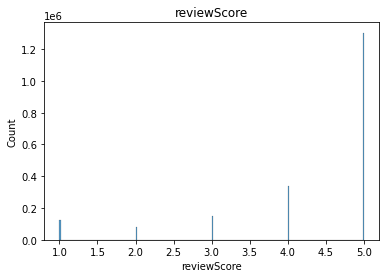

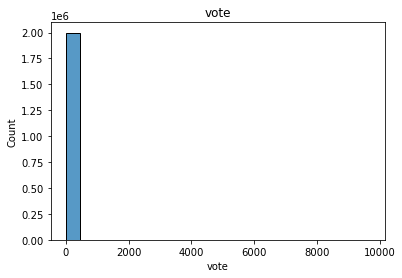

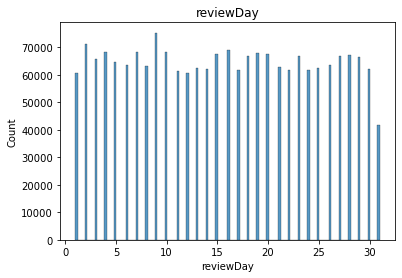

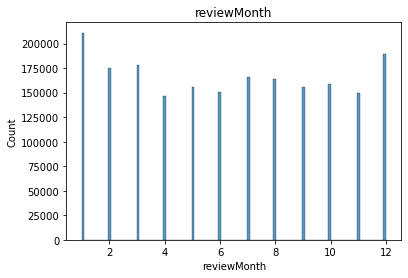

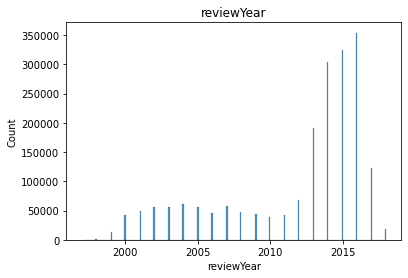

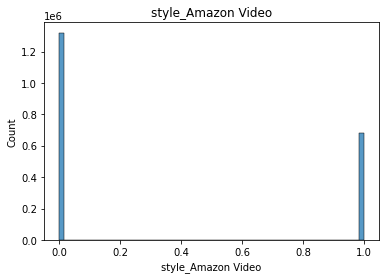

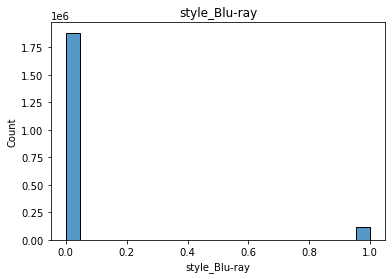

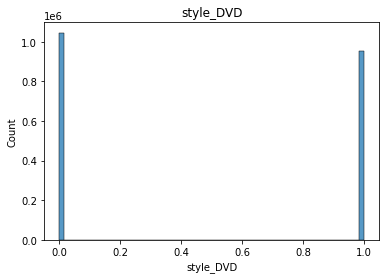

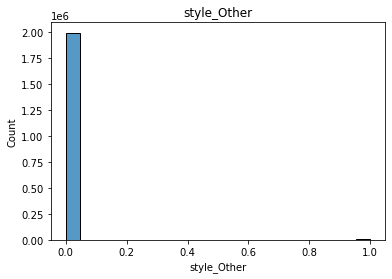

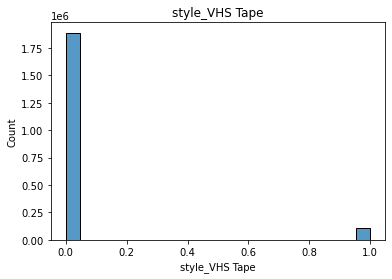

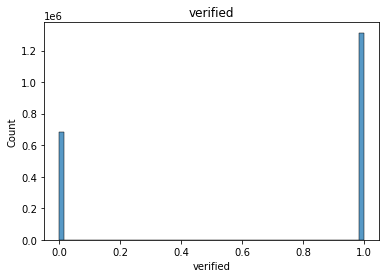

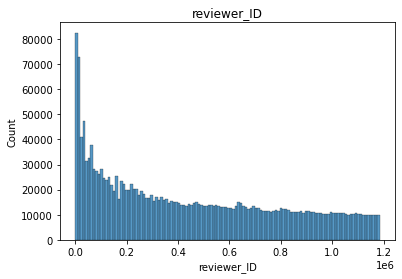

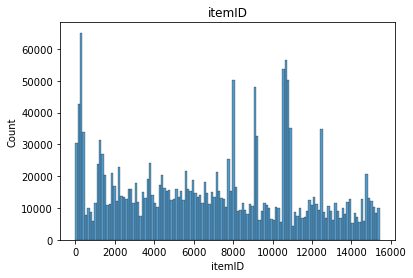

In [43]:
for column in clean_df.columns:
    sns.histplot(x = column, data = clean_df)
    plt.title(column)
    plt.show()

Non of the data in the columns look normally distributed. Thus the linear regression model will fit the data poorly. The `reviewScore` is left skewed with most of the data rated at 5. The `unixReviewTime` is also left skewed with a spike in reviews in the unixTime of about 1.35e9. The `vote` column seems to only have one bar close to 0 which could indicate that the majority of the reviews had low votes from other Amazon users and there is a very small percentage of high vote counts. This datetime represents 2012 which could be due to a spike in Amazon usage. The `style` data only contains 1s and 0s since they were dummy encoded thus, it doesn't make sense to look at the histograms for those data. (Histograms are used for continuous data). The `reviewer_ID` and `ItemID` columns are not ordinal data, so looking at a histogram can be misleading. Spikes in the data just mean a person is reviewing a lot of products for `reviewer_ID` and spikes in `itemID` mean that some products are being reviewed a lot of times. 

In [44]:
datetime.fromtimestamp(1350000000)

datetime.datetime(2012, 10, 11, 20, 0)

### Check the values in the vote column

In [45]:
clean_df['vote'].value_counts()

0       1585389
2        123974
3         71423
4         46756
5         32769
         ...   
437           1
259           1
444           1
445           1
1009          1
Name: vote, Length: 498, dtype: int64

Most reviews had 0 votes and many reviews had below 5 votes.

In [46]:
clean_df['vote'].value_counts().head(1)/clean_df.shape[0]

0    0.793236
Name: vote, dtype: float64

About 79% of the reviews have 0 votes which is an extremely high percentage that will certainly skew the `vote` data

Show correlations between different features

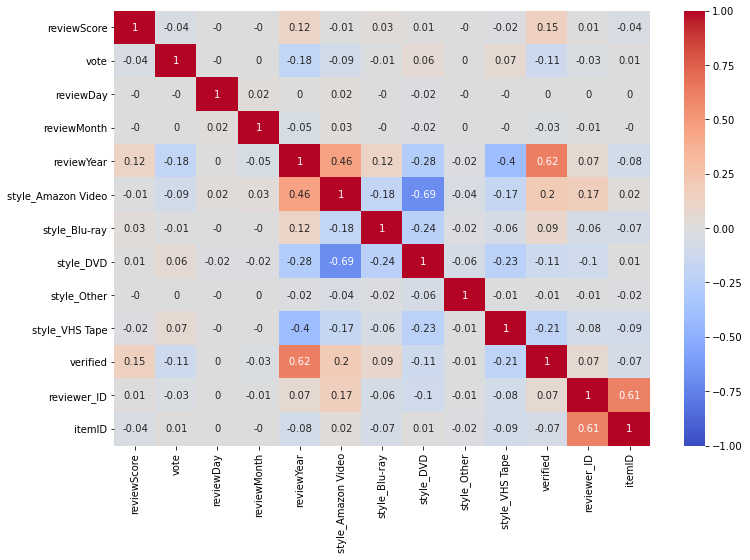

In [47]:
plt.figure(figsize= [12,8])
sns.heatmap(clean_df.corr().round(2), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

# 4. Simple Modeling<a class ='anchor' id='4Simple_Model'></a>

In [48]:
X = clean_df.drop(columns =['vote','itemID'])
Y = clean_df['vote']

X_withconstant = sm.add_constant(X)

In [49]:
rmodel1 = sm.OLS(Y,X_withconstant)

rmodel1 = rmodel1.fit()

rmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vote   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     6062.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:11:32   Log-Likelihood:            -7.9019e+06
No. Observations:             1998634   AIC:                         1.580e+07
Df Residuals:                 1998622   BIC:                         1.580e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                915.3816      5.493    166.631      0.000     904.615     926.149
reviewScore           -0.2570      0.008    -32.971      0.000      -0.272      -0.242
reviewDay              0.0005      0.001      0.535      0.593      -0.001       0.003
reviewMonth           -0.0155      0.003     -6.184      0.000      -0.020      -0.011
reviewYear            -0.4539      0.003   -165.886      0.000      -0.459      -0.449
style_Amazon Video     0.7932      0.039     20.120      0.000       0.716       0.870
style_Blu-ray          1.5735      0.051     30.613      0.000       1.473       1.674
style_DVD              0.9267      0.037     24.873      0.000       0.854       1.000
style_Other            0.6246      0.150      4.159      0.000       0.330       0.919
style_VHS Tape         0.8088      0.054     14.979      0.000       0.703       0.915
verified               0.1569      0.024      6.449      0.000       0.109       0.205
reviewer_ID        -6.919e-07   2.56e-08    -27.011      0.000   -7.42e-07   -6.42e-07
================================================================================
Omnibus:                 10744152.580   Durbin-Watson:                     1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2888683748417572.500
Skew:                         279.147   Prob(JB):                           0.00
Kurtosis:                  186249.034   Cond. No.                       3.53e+08
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Read in the clean meta data and combine it with the clean review data

In [50]:
# meta_df = pd.read_csv('clean_meta.csv')
# meta_df

In [51]:
# clean_df['asin'] = review_df['asin']

In [52]:
# new_df = pd.merge(clean_df, meta_df,  how='left', left_on='asin', right_on = 'asin')

In [53]:
review_df.head()

,reviewScore,verified,reviewTime,reviewerID,asin,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape
0,5,True,2013-03-11,A3478QRKQDOPQ2,0001527665,0,11,3,2013,0,0,0,0,1
1,5,True,2013-02-18,A2VHSG6TZHU1OB,0001527665,3,18,2,2013,1,0,0,0,0
2,5,False,2013-01-17,A23EJWOW1TLENE,0001527665,0,17,1,2013,1,0,0,0,0
3,5,True,2013-01-10,A1KM9FNEJ8Q171,0001527665,0,10,1,2013,1,0,0,0,0
4,4,True,2012-12-26,A38LY2SSHVHRYB,0001527665,0,26,12,2012,1,0,0,0,0
